In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  CWD = '/content/drive/MyDrive/DataSources/SkinCare'
  os.chdir(CWD)
except:None
G_path = './Project_Data'

In [2]:
import numpy as np
import os
import torch
import shutil
import matplotlib.pyplot as plt
import matplotlib as mtl
import seaborn as sns
import warnings
import re
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from statistics import mean
import sklearn as sk
import warnings
from sklearn.utils import resample
import pickle as pickle
import PIL as pl
import pandas as pd
from PIL.Image import Transpose
from PIL import Image
import features
from features.usefull_functions import *
from features.NETs import *
from features.Model_Training import *
warnings.filterwarnings('ignore')

# **Import Meta Data**

In [3]:
file = 'HAM10000_metadata.csv'
meta_data_v0 = pd.read_csv(G_path + '/00_HAM1000_DataSet/' + file)

label_description = {
    "akiec" : "Actinic keratoses ", # very early form of skin cancer 
    "bcc" : "basal cell carcinoma" , # basal-cell cancer or white skin cancer
    "bkl" : "keratosis-like", # non-cancerous skin tumour
    "df" : "dermatofibroma", # non-cancerous rounded bumps 
    "mel" : "melanoma", # black skin cancer
    "nv" : "melanocytic nevi", # mole non-cancerous
    "vasc" : "vascular", # skin condition
}

meta_data_v0['label_description'] = meta_data_v0['dx']
meta_data_v0 = meta_data_v0.replace({'label_description':label_description})

In [4]:
# Remove Duplication
meta_data_noDup = meta_data_v0.groupby('lesion_id').first().reset_index()
# Encode Labels
meta_data_noDup.dx = pd.Categorical(meta_data_noDup.dx)
meta_data_noDup['image_label'] = meta_data_noDup.dx.cat.codes

remap = {0:1 , 1:1, 4:1, 2:0, 3:0, 5:0, 6:0}
meta_data_noDup['binary_label'] = meta_data_noDup['image_label']
meta_data_noDup = meta_data_noDup.replace({'binary_label':remap})

meta_data_noDup.to_csv(G_path + '/02_Augmented_MetaData/' + 'Meta_data_noDup.csv')
### insert the code of R for Age filling

######################
filled_nan_ages = pd.read_csv(G_path + '/02_Augmented_MetaData/'+'/no_duplicates_no_NAs.csv').rename(columns={'age':'age_mdf'})

meta_data_noDup = meta_data_noDup.merge(filled_nan_ages,how='left', on='lesion_id')
meta_data_noDup['age'] = meta_data_noDup.apply(lambda x: x.age if pd.notnull(x.age) else x.age_mdf, axis=1)

try: meta_data_noDup.drop(columns=['Unnamed: 0','age_mdf'],inplace=True)
except: None
# Reduce Nr. class 5 category to 2800
class_5 = meta_data_noDup[meta_data_noDup.image_label==5]
class_5_reduced = class_5.sample(n=2000, random_state=0)
meta_data_noDup_reduced = pd.concat([meta_data_noDup[meta_data_noDup.image_label!=5],class_5_reduced],axis=0)
# Get 
train_meta, test_valid_meta = train_test_split(meta_data_noDup_reduced, test_size = 0.2, random_state=0,stratify=meta_data_noDup_reduced['image_label'])
test_meta, valid_meta = train_test_split(test_valid_meta, test_size = 0.5, random_state=0,stratify=test_valid_meta['image_label'])

In [5]:
train_meta['type'] = 'train'
valid_meta['type'] = 'valid'
test_meta['type'] = 'test'
blc_test_meta = pd.concat([valid_meta,test_meta],axis=0)
# blc_test_meta = blc_test_meta.groupby('image_label').head(15).reset_index()
blc_test_meta = blc_test_meta.groupby('image_label').sample(n=15,random_state=0)
pickle.dump(blc_test_meta , open(G_path + '/02_Augmented_MetaData/'+ '/balanced_test_set','wb'))
blc_test_meta.to_csv(G_path+'/02_Augmented_MetaData/' +'balanced_test_set.csv' )

# **Import Images**

In [8]:
img_list = []
for path, dirs, files in  os.walk(G_path + '/00_HAM1000_DataSet'):
    for f in files:
        img_list.append( path +'/' + f)
    for d in dirs:
        img_list.append( path + d)
img_list = list(set([x for x in img_list if ".jpg" in x] ))

print(len(img_list))

10015


In [9]:
# Copy Images for Augmentation Directory
Augment_Path = G_path + '/' + '01_Augmented_Imaged'
try:
    os.makedirs(Augment_Path)
except:
    None
try:
    os.makedirs(Augment_Path+'/test')
    os.makedirs(Augment_Path+'/valid')
    os.makedirs(Augment_Path+'/train')
except:
    None
labels = list(train_meta.image_label.unique())

for i in labels:
    try:
        os.makedirs(Augment_Path+'/test/'+str(i))
        os.makedirs(Augment_Path+'/valid/'+str(i))
        os.makedirs(Augment_Path+'/train/'+str(i))
    except:
        None

In [ ]:
data_ = train_meta[['image_id','image_label']]
name = 'train'
def copy_to_AutoEncoder(data_ , name):
    id_list = list(data_['image_id'])
    id_labels = list(data_['image_label'])

    for i in tqdm(range(len(id_list))):
        for j in img_list:
            if id_list[i] in j:
                shutil.copy(j, Augment_Path+'/' + name+ '/' + str(id_labels[i]) + '/' + id_list[i] + '.jpg')
                break

data_ = train_meta[['image_id','image_label']]
name = 'train'
copy_to_AutoEncoder(data_ = data_ , name = name)
data_ = valid_meta[['image_id','image_label']]
name = 'valid'
copy_to_AutoEncoder(data_ = data_ , name = name)
data_ = test_meta[['image_id','image_label']]
name = 'test'
copy_to_AutoEncoder(data_ = data_ , name = name)

# **Data Augmentation**

In [10]:
folder_dir = Augment_Path + '/train/'

for i in [3, 6, 0, 1]:
    f = folder_dir + str(i) + "/"
    for image in tqdm(os.listdir(f)):
        if "ISIC" in image and "AUG" not in image and image.replace(".jpg", ""):
            # print("Augmented image: ", image)
            im1 = Image.open(f + image)
            augmented1 = im1.transpose(Transpose.FLIP_LEFT_RIGHT)
            augmented2 = im1.transpose(Transpose.FLIP_TOP_BOTTOM)
            augmented3 = im1.transpose(Transpose.ROTATE_180)
            augmented1.save(folder_dir + "/" + str(i) + "/AUG1_" + image)
            augmented2.save(folder_dir + "/" + str(i) + "/AUG2_" + image)
            augmented3.save(folder_dir + "/" + str(i) + "/AUG3_" + image)
            # Add metadata of Augmented image
            for j in range(1,4):
                new_row = train_meta[train_meta.image_id == image.replace(".jpg", "")]
                Aug_label = 'AUG'+str(j)+'_' + new_row['image_id'].iloc[0]
                if not train_meta.image_id.str.contains(Aug_label).any():
                    new_row['image_id'] = 'AUG'+str(j)+'_' + new_row['image_id'].iloc[0]
                    train_meta = train_meta.append(new_row)

100%|██████████| 263/263 [00:06<00:00, 43.51it/s]


In [12]:
Meta_Data_Augmented = pd.concat([train_meta, valid_meta, test_meta], axis=0)
pickle.dump(Meta_Data_Augmented , open(G_path + '/02_Augmented_MetaData/'+ '/Meta_Data_Augmented','wb'))
Meta_Data_Augmented.to_csv(G_path+'/02_Augmented_MetaData/' +'Meta_Data_Augmented.csv' )

In [13]:
Meta_Data_Augmented.label_description.value_counts()

melanocytic nevi        2000
basal cell carcinoma    1113
Actinic keratoses        774
keratosis-like           727
melanoma                 614
vascular                 332
dermatofibroma           247
Name: label_description, dtype: int64

Text(0.5, 1.0, 'Nr. of Images by lesions')

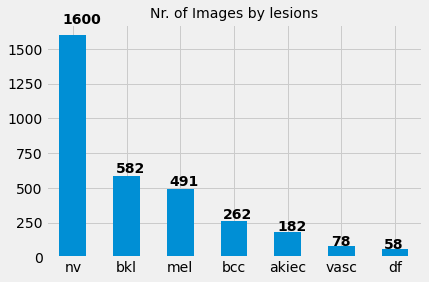

In [21]:
df_ = Meta_Data_Augmented[Meta_Data_Augmented.type.str.contains('test|valid')]
df_ = train_meta[~train_meta.image_id.str.contains('AUG')]
mtl.style.use('fivethirtyeight')
fig, ax = plt.subplots()
# sns.set_style("dark")
count = df_.dx.value_counts()
count.plot(kind='bar')

for i, v in enumerate(count):
    ax.text(i -0.2, v*1.05, str(v), fontweight='bold')
# for i in range(len(count)):
#     plt.text(x= count[i],y= i,s= count[i], c='b')
plt.xticks(rotation=0, horizontalalignment="center", fontsize=14)
plt.title("Nr. of Images by lesions", fontsize=14)
# plt.xlabel("Skin Lesions", fontsize=14)
# plt.ylabel("Nr. Images")